In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklic earn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import warnings
warnings.filterwarnings('ignore')
#from sklearn import set_config
#set_config(display='diagram')

%matplotlib inline

In [2]:
df = pd.read_csv('AER_credit_card_data.csv')
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [3]:
# Convert target value 'card' to 1s and 0s
display('Before', df.card.value_counts())
mapping = {'yes': 1, 'no': 0}
df.card.replace(mapping, inplace=True)
display('After', df.card.value_counts())

'Before'

yes    1023
no      296
Name: card, dtype: int64

'After'

1    1023
0     296
Name: card, dtype: int64

#### EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   card         1319 non-null   int64  
 1   reports      1319 non-null   int64  
 2   age          1319 non-null   float64
 3   income       1319 non-null   float64
 4   share        1319 non-null   float64
 5   expenditure  1319 non-null   float64
 6   owner        1319 non-null   object 
 7   selfemp      1319 non-null   object 
 8   dependents   1319 non-null   int64  
 9   months       1319 non-null   int64  
 10  majorcards   1319 non-null   int64  
 11  active       1319 non-null   int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 123.8+ KB


In [5]:
df.describe()

,card,reports,age,income,share,expenditure,dependents,months,majorcards,active
count,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000
mean,0.775588,0.456406,33.213103,3.365376,0.068732,185.057071,0.993935,55.267627,0.817286,6.996967
std,0.417353,1.345267,10.142783,1.693902,0.094656,272.218917,1.247745,66.271746,0.386579,6.305812
min,0.000000,0.000000,0.166667,0.210000,0.000109,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,25.416670,2.243750,0.002316,4.583333,0.000000,12.000000,1.000000,2.000000
50%,1.000000,0.000000,31.250000,2.900000,0.038827,101.298300,1.000000,30.000000,1.000000,6.000000
75%,1.000000,0.000000,39.416670,4.000000,0.093617,249.035800,2.000000,72.000000,1.000000,11.000000
max,1.000000,14.000000,83.500000,13.500000,0.906320,3099.505000,6.000000,540.000000,1.000000,46.000000


In [6]:
df.isnull().sum()

card           0
reports        0
age            0
income         0
share          0
expenditure    0
owner          0
selfemp        0
dependents     0
months         0
majorcards     0
active         0
dtype: int64

In [7]:
df.nunique()

card              2
reports          13
age             418
income          431
share          1162
expenditure     981
owner             2
selfemp           2
dependents        7
months          193
majorcards        2
active           35
dtype: int64

In [8]:
# Splitting dataset 60%-20%-20%

target = df.card
data = df.drop(columns='card')

dfTrainFull, dfTest, yTrainFull, yTest  = train_test_split(data, target, test_size=0.2, random_state=1)
dfTrain, dfVal, yTrain, yVal  = train_test_split(dfTrainFull, yTrainFull, test_size=0.25, random_state=1)
len(dfTrain) ,len(dfVal), len(dfTest), len(yTrain), len(yVal), len(yTest)

(791, 264, 264, 791, 264, 264)

In [9]:
numericalCols = list(dfTrain.select_dtypes(exclude=object).columns)
categoricalCols = list(dfTrain.select_dtypes(include=object).columns)
allCols = list(dfTrain.columns)
print(f'Numerical columns: {numericalCols}\n')
print(f'Categorical columns: {categoricalCols}')

Numerical columns: ['reports', 'age', 'income', 'share', 'expenditure', 'dependents', 'months', 'majorcards', 'active']

Categorical columns: ['owner', 'selfemp']


#### Variable with hights correlation

In [10]:
res = {}

for col in numericalCols:
    auc = roc_auc_score(yTrain, dfTrain[col])
    if auc < 0.5:
        auc = roc_auc_score(yTrain, -dfTrain[col])
    res[col] = auc
    print(auc)

0.7166629860689376
0.5240020979407055
0.5908049467233478
0.989183643423692
0.991042345276873
0.5327757227773791
0.5294217780967629
0.5343859842838476
0.6043173411362006


In [11]:
res.get('reports'), res.get('dependents'), res.get('active'), res.get('share')

(0.7166629860689376, 0.5327757227773791, 0.6043173411362006, 0.989183643423692)

The one with the highest correlation is the feature 'share'

#### Training the model

In [12]:
dictsTrain = dfTrain[allCols].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
XTrain = dv.fit_transform(dictsTrain)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(XTrain, yTrain)

LogisticRegression(max_iter=1000, solver='liblinear')

In [13]:
dictsVal = dfVal[allCols].to_dict(orient='records')
XVal = dv.transform(dictsVal)
yPred = model.predict_proba(XVal)[:,1]

In [14]:
auc = roc_auc_score(yVal, yPred)
auc

0.995171242063847

#### Precision and recall

In [15]:
def PrecisionRecall(yVal, yPred):
    scores = []
    thresholds = np.linspace(0, 1, 101)
    
    for threshold in thresholds:
        yPred = (model.predict_proba(XVal)[0:,1] > threshold) * 1
        cm = confusion_matrix(yVal, yPred)
        tn, fp, fn, tp = cm.ravel()
        p = round(tp / (fp + tp),2)
        r = round(tp / (tp + fn),2)
        scores.append((threshold, tn, fp, fn, tp, p, r))
        
        columns = ['threshold', 'tn', 'fp', 'fn', 'tp', 'p', 'r']
        dfScores = pd.DataFrame(scores, columns=columns)
        
    return dfScores

In [16]:
scores = PrecisionRecall(yVal, yPred)
scores

,threshold,tn,fp,fn,tp,p,r
0,0.00,0,53,0,211,0.80,1.00
1,0.01,19,34,0,211,0.86,1.00
2,0.02,22,31,0,211,0.87,1.00
3,0.03,29,24,0,211,0.90,1.00
4,0.04,31,22,0,211,0.91,1.00
...,...,...,...,...,...,...,...
96,0.96,53,0,7,204,1.00,0.97
97,0.97,53,0,8,203,1.00,0.96
98,0.98,53,0,8,203,1.00,0.96
99,0.99,53,0,9,202,1.00,0.96


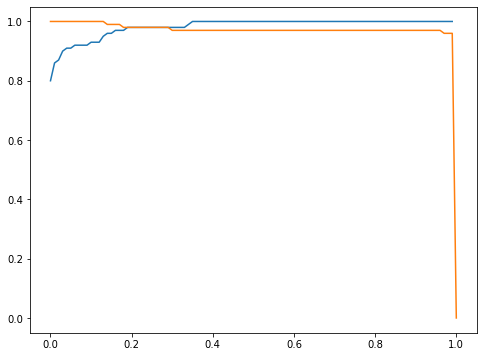

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(scores.threshold, scores.p)
plt.plot(scores.threshold, scores.r)
_ = plt.show()

In [18]:
scores[scores.p == scores.r]

,threshold,tn,fp,fn,tp,p,r
19,0.19,48,5,4,207,0.98,0.98
20,0.20,48,5,4,207,0.98,0.98
21,0.21,48,5,4,207,0.98,0.98
22,0.22,48,5,4,207,0.98,0.98
23,0.23,48,5,4,207,0.98,0.98
24,0.24,48,5,5,206,0.98,0.98
25,0.25,48,5,5,206,0.98,0.98
26,0.26,48,5,5,206,0.98,0.98
27,0.27,48,5,5,206,0.98,0.98
28,0.28,48,5,5,206,0.98,0.98


Graphs intersect between 0.2 and 0.3 (threshold)

#### Calculating F1

In [19]:
scores['f1'] = 2 * scores.p * scores.r / (scores.p + scores.r)
scores[::10]

,threshold,tn,fp,fn,tp,p,r,f1
0,0.0,0,53,0,211,0.80,1.00,0.888889
10,0.1,36,17,1,210,0.93,1.00,0.963731
20,0.2,48,5,4,207,0.98,0.98,0.980000
30,0.3,48,5,6,205,0.98,0.97,0.974974
40,0.4,52,1,6,205,1.00,0.97,0.984772
50,0.5,52,1,7,204,1.00,0.97,0.984772
60,0.6,52,1,7,204,1.00,0.97,0.984772
70,0.7,52,1,7,204,1.00,0.97,0.984772
80,0.8,52,1,7,204,1.00,0.97,0.984772
90,0.9,53,0,7,204,1.00,0.97,0.984772


Maximun F1 score starts at threshold = 0.4

#### KFold Cross-Validation

In [20]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categoricalCols + numericalCols].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [21]:
def predict(df, dv, model):
    dicts = df[categoricalCols + numericalCols].to_dict(orient='records')
    
    X = dv.transform(dicts)
    
    y_pred = model.predict_proba(X)[:,1]
    
    return y_pred

In [22]:
newDfTrainFull = dfTrainFull.copy()
newDfTrainFull['card'] = yTrainFull.values
newDfTrainFull

,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active,card
710,1,36.83333,3.0000,0.000400,0.000000,yes,no,1,12,1,16,0
1258,0,35.58333,3.5606,0.109084,323.587500,no,no,0,12,1,0,1
435,0,25.66667,2.0000,0.004900,7.416667,no,no,0,26,1,13,1
987,0,25.58333,1.7500,0.000686,0.000000,no,no,0,108,0,0,0
1286,1,48.66667,6.0000,0.177017,885.085800,yes,no,3,114,1,19,1
...,...,...,...,...,...,...,...,...,...,...,...,...
715,0,38.33333,5.0000,0.057248,238.365000,yes,no,3,9,1,0,1
905,1,32.50000,10.0000,0.037040,308.250000,yes,no,3,35,1,4,1
1096,0,19.16667,1.9000,0.282962,448.023300,no,no,0,192,0,1,1
235,0,30.83333,3.0000,0.062629,156.572500,yes,no,2,72,1,8,1


In [23]:
from tqdm.auto import tqdm
from sklearn.model_selection import KFold

n_splits = 5

for C in tqdm([1.0]):
    
    kfold = KFold(n_splits = n_splits, shuffle = True, random_state=1)   
    ausc = []
    
    for train_idx, val_idx in kfold.split(newDfTrainFull):
        df_train = newDfTrainFull.iloc[train_idx]
        df_val = newDfTrainFull.iloc[val_idx]
        y_train = df_train.card.values
        y_val = df_val.card.values
       
        dv, model = train(df_train[categoricalCols + numericalCols], y_train, C=C)
        newTargetPredict = predict(df_val[categoricalCols + numericalCols], dv, model)
        
        auc = roc_auc_score(df_val.card, newTargetPredict)
        
        ausc.append(auc)       
        
    print('C = %s - Mean AUC = %.3f +- %.3f' % (C, np.mean(ausc), np.std(ausc)))

  0%|          | 0/1 [00:00<?, ?it/s]

C = 1.0 - Mean AUC = 0.996 +- 0.003


the std = 0.003

In [24]:
from tqdm.auto import tqdm
from sklearn.model_selection import KFold

n_splits = 5

for C in tqdm([1e-2, 0.1, 1, 10]):
    
    kfold = KFold(n_splits = n_splits, shuffle = True, random_state=1)   
    ausc = []
    
    for train_idx, val_idx in kfold.split(newDfTrainFull):
        df_train = newDfTrainFull.iloc[train_idx]
        df_val = newDfTrainFull.iloc[val_idx]
        y_train = df_train.card.values
        y_val = df_val.card.values
       
        dv, model = train(df_train[categoricalCols + numericalCols], y_train, C=C)
        newTargetPredict = predict(df_val[categoricalCols + numericalCols], dv, model)
        
        auc = roc_auc_score(df_val.card, newTargetPredict)
        
        ausc.append(auc)       
        
    print('C = %s - Mean AUC = %.3f +- %.3f' % (C, np.mean(ausc), np.std(ausc)))

  0%|          | 0/4 [00:00<?, ?it/s]

C = 0.01 - Mean AUC = 0.995 +- 0.004
C = 0.1 - Mean AUC = 0.997 +- 0.003
C = 1 - Mean AUC = 0.996 +- 0.003
C = 10 - Mean AUC = 0.997 +- 0.003


C = 0.1 - Mean AUC = 0.997 +- 0.003 will be the best option in this case